<a href="https://colab.research.google.com/github/islammohamedd1/gp/blob/main/stocks_prediction_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stocks Prediction

In [ ]:
import IPython
import IPython.display

%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



In [ ]:
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.figsize'] = [12, 8]

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('/content/drive/MyDrive/GP/Datasets/huge-stock-market-dataset/Stocks/msft.us.txt', index_col='Date', parse_dates=['Date'], date_parser=dateparse)
print(len(df))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


7983


In [ ]:
df = df.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low', 'Volume': 'volume'})
df = df.drop(columns=['OpenInt'])

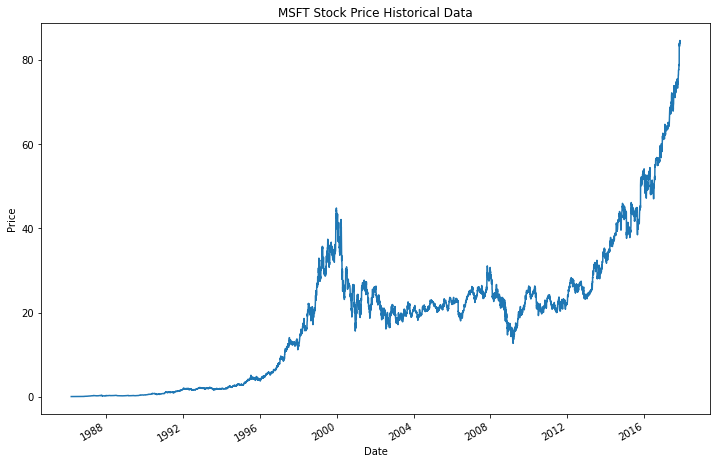

In [ ]:
df['close'].plot()
plt.title('MSFT Stock Price Historical Data')
plt.ylabel('Price')
plt.show()

In [ ]:
df.describe()

,open,high,low,close,volume
count,7983.000000,7983.000000,7983.000000,7983.000000,7.983000e+03
mean,18.977859,19.187219,18.773635,18.984698,7.945800e+07
std,16.416068,16.552604,16.277882,16.424012,5.214889e+07
min,0.067200,0.067200,0.067200,0.067200,0.000000e+00
25%,2.113300,2.155100,2.079700,2.113300,4.910587e+07
50%,20.462000,20.697000,20.251000,20.469000,7.059385e+07
75%,25.475000,25.754000,25.233000,25.483500,9.734927e+07
max,84.770000,86.200000,84.082500,84.560000,1.371331e+09


In [ ]:
df['change'] = df.close.pct_change()

In [ ]:
df[['change', 'close']].head(2)

,change,close
Date,,
1986-03-13,NaN,0.07533
1986-03-14,0.0,0.07533


In [ ]:
df['log_change'] = np.log(1 + df.change)

In [ ]:
df.dropna(inplace=True)

In [ ]:
scaler = MinMaxScaler()
df.close = scaler.fit_transform(df.close.values.reshape(-1, 1))
df.open = scaler.fit_transform(df.open.values.reshape(-1, 1))
df.high = scaler.fit_transform(df.high.values.reshape(-1, 1))
df.low = scaler.fit_transform(df.low.values.reshape(-1, 1))
df.volume = scaler.fit_transform(df.volume.values.reshape(-1, 1))
df.change = scaler.fit_transform(df.change.values.reshape(-1, 1))
df.log_change = scaler.fit_transform(df.log_change.values.reshape(-1, 1))

Split the data using (70, 20, 10)

In [ ]:
df.isna().sum()

open          0
high          0
low           0
close         0
volume        0
change        0
log_change    0
dtype: int64

In [ ]:
df = df[['close', 'log_change', 'volume']]
df.head()

,close,log_change,volume
Date,,,
1986-03-14,0.000096,0.666614,0.390725
1986-03-17,0.000096,0.666614,0.168852
1986-03-18,0.000096,0.666614,0.085923
1986-03-19,0.000096,0.666614,0.060727
1986-03-20,0.000096,0.666614,0.074092


In [ ]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features

3

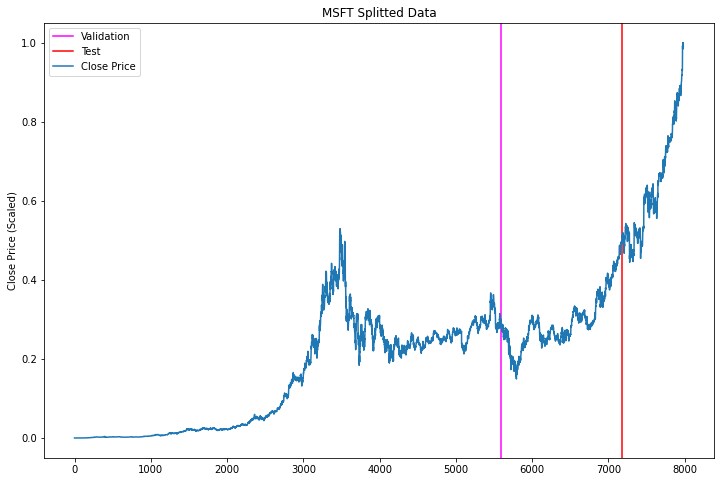

In [ ]:
plt.axvline(x=len(train_df), color='magenta')
plt.axvline(x=len(train_df) + len(val_df), color='red')
plt.plot(range(len(df)), df.close)
plt.legend(['Validation', 'Test', 'Close Price'])
plt.title('MSFT Splitted Data')
plt.ylabel('Close Price (Scaled)')
plt.show()

## Window Generator

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, 
                 val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # wirk out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i,
                                          name in enumerate(label_columns)}
        self.column_indices = {name: i for i,
                               name in enumerate(train_df.columns)}
        
        # work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [ ]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=256,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
def plot(self, model=None, plot_col='close', max_subplots=3, title=None):
    inputs, labels = self.example
    # plt.figure(figsize=(24, 32))
    if title:
        plt.suptitle(title)
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_subplots, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()
    
    plt.xlabel('Time')
    plt.show()

WindowGenerator.plot = plot

In [ ]:
def plot_series(self, model, plot_col='close', series=test_df, start=0, title=None):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(self.total_window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(self.total_window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    forecast = forecast[:-1, -1, 0]
    plt.plot(np.array(range(len(series[plot_col][start + self.label_width:]))), 
                series[plot_col][start + self.label_width:], '-')
    plt.plot(np.array(range(len(forecast[start:]))), forecast[start:], '-')

    plt.title(title)
    plt.legend(['Actual', 'Prediction'])
    plt.xlabel('Time')
    plt.show()

        
WindowGenerator.plot_series = plot_series

In [ ]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
val_performance = {}
performance = {}

In [ ]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.metrics.MeanAbsolutePercentageError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

## Multi-Step Models

### Window the data

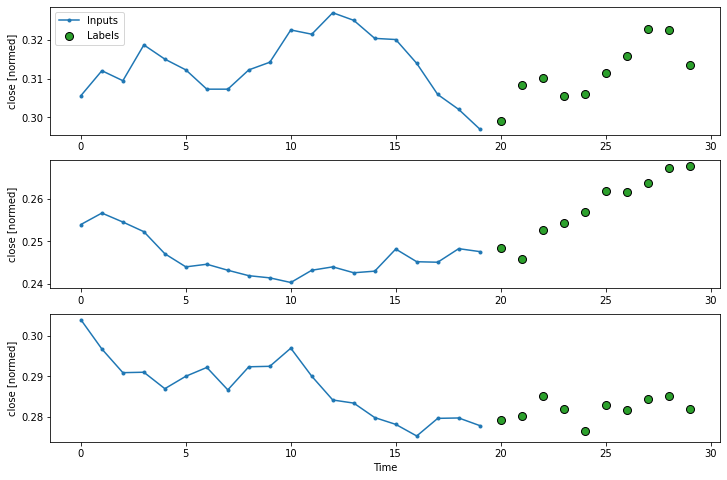

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['close']

In [ ]:
OUT_STEPS = 10
multi_window = WindowGenerator(input_width=20, label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns=['close'])
multi_window.plot()
multi_window

In [ ]:
multi_val_performance = {}
multi_performance = {}

#### Dense model

In [ ]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

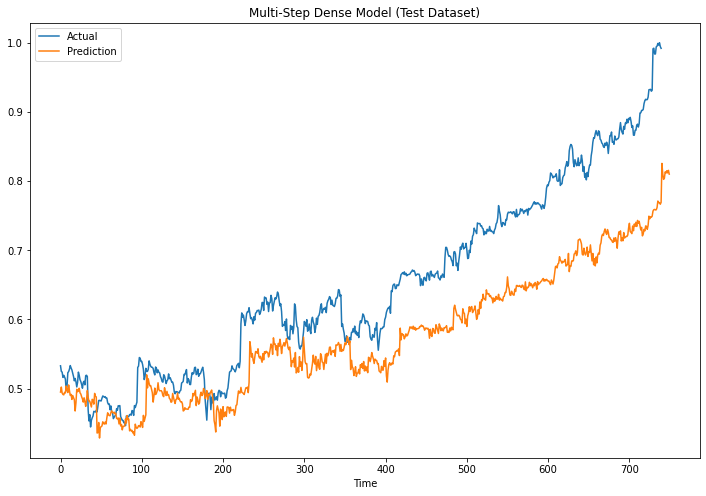

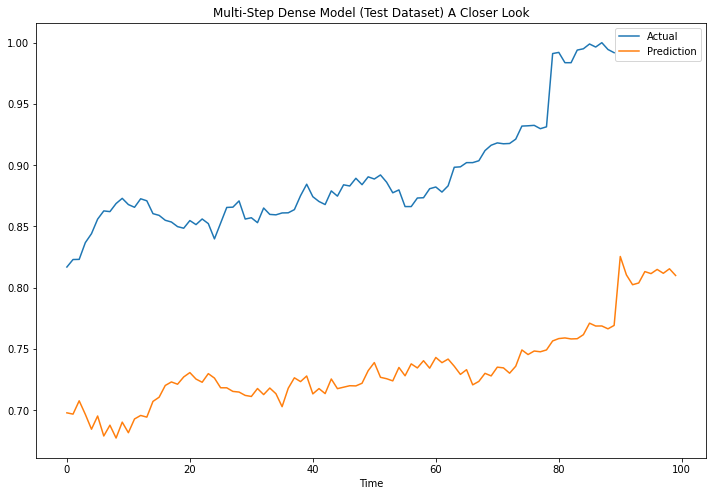

In [ ]:
multi_window.plot_series(multi_dense_model, title="Multi-Step Dense Model (Test Dataset)", start=-750)
multi_window.plot_series(multi_dense_model, title="Multi-Step Dense Model (Test Dataset) A Closer Look", start=-100)

#### CNN

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(512, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

7/7 [==============================] - 0s 5ms/step - loss: 1.2211e-04 - mean_absolute_error: 0.0082 - mean_absolute_percentage_error: 2.8745


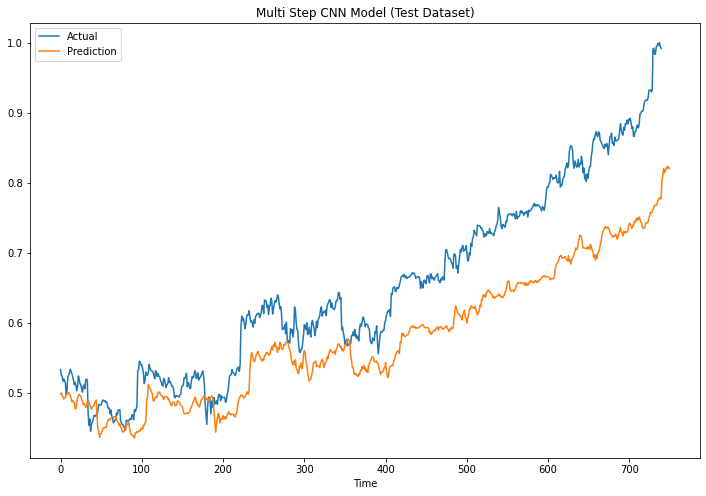

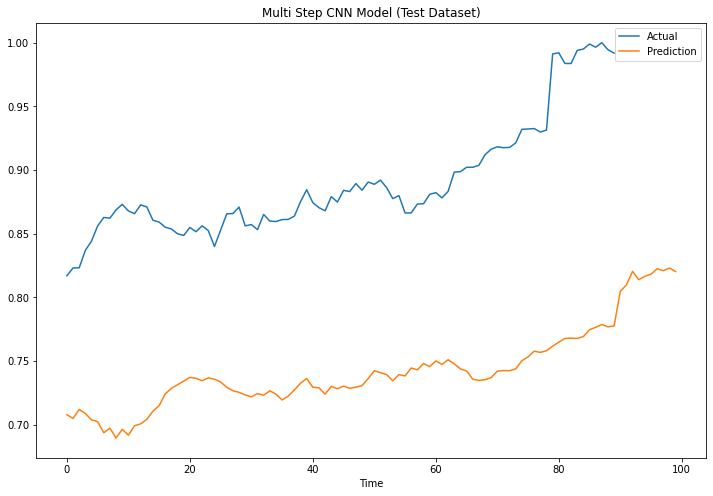

In [ ]:
multi_window.plot_series(multi_conv_model, title="Multi Step CNN Model (Test Dataset)", start=-750)
multi_window.plot_series(multi_conv_model, title="Multi Step CNN Model (Test Dataset)", start=-100)

#### RNN LSTM

In [ ]:
tf.keras.backend.clear_session()
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(1024, return_sequences=True),
    tf.keras.layers.LSTM(512, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

7/7 [==============================] - 0s 18ms/step - loss: 1.4011e-04 - mean_absolute_error: 0.0090 - mean_absolute_percentage_error: 3.2585


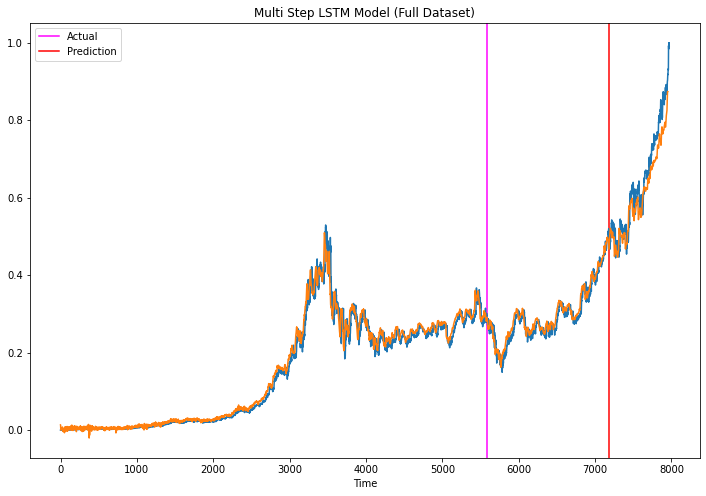

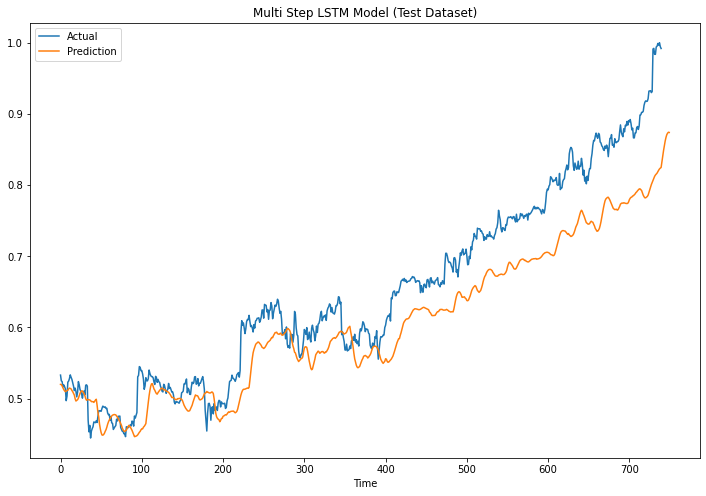

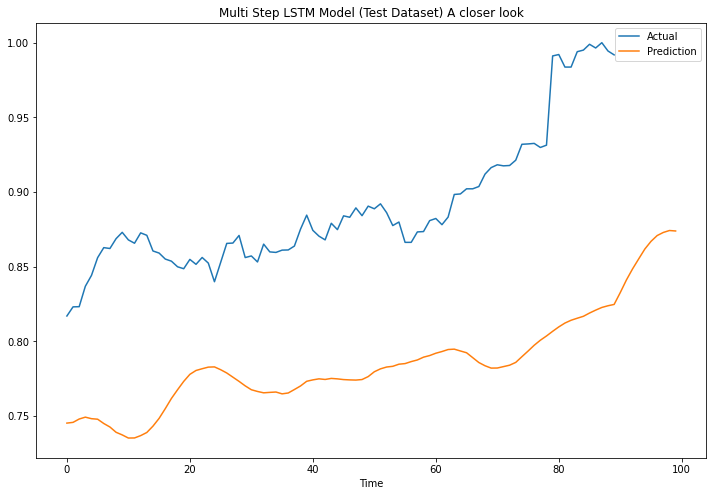

In [ ]:
plt.axvline(x=len(train_df), color='magenta')
plt.axvline(x=len(train_df) + len(val_df), color='red')
multi_window.plot_series(multi_lstm_model, title="Multi Step LSTM Model (Full Dataset)", series=df)
multi_window.plot_series(multi_lstm_model, title="Multi Step LSTM Model (Test Dataset)", start=-750)
multi_window.plot_series(multi_lstm_model, title="Multi Step LSTM Model (Test Dataset) A closer look", start=-100)

In [ ]:
tf.keras.backend.clear_session()

gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(1042, return_sequences=True),
    tf.keras.layers.GRU(512, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(gru_model, multi_window)

IPython.display.clear_output()

multi_val_performance['GRU'] = gru_model.evaluate(multi_window.val)
multi_performance['GRU'] = gru_model.evaluate(multi_window.test, verbose=0)

7/7 [==============================] - 0s 20ms/step - loss: 1.1280e-04 - mean_absolute_error: 0.0080 - mean_absolute_percentage_error: 2.8809


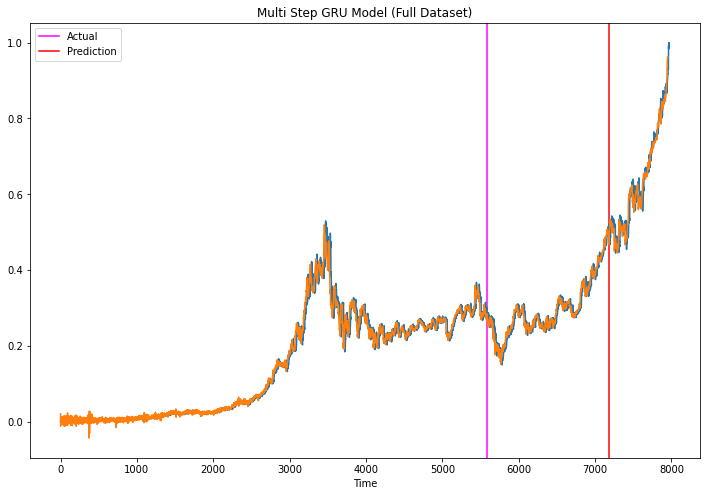

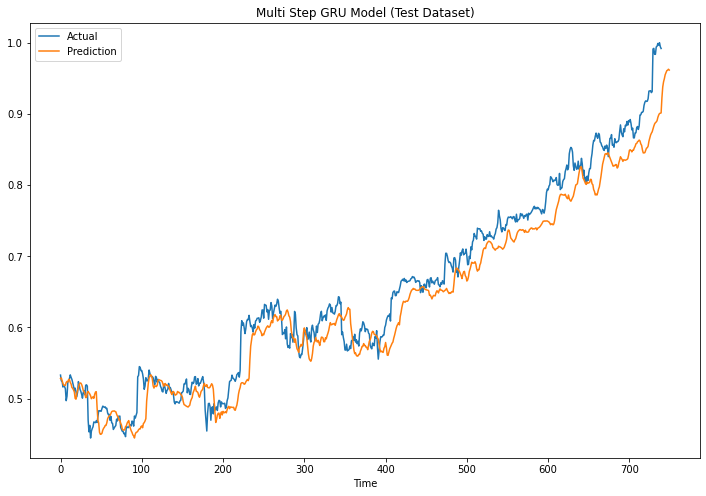

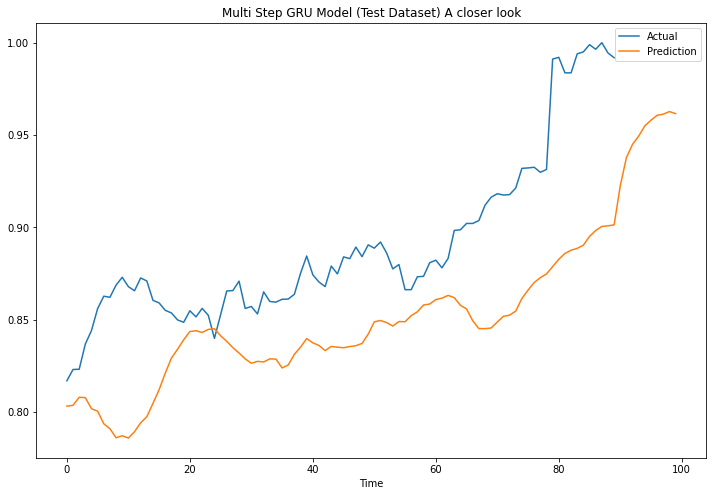

In [ ]:
plt.axvline(x=len(train_df), color='magenta')
plt.axvline(x=len(train_df) + len(val_df), color='red')
multi_window.plot_series(gru_model, title="Multi Step GRU Model (Full Dataset)", series=df)
multi_window.plot_series(gru_model, title="Multi Step GRU Model (Test Dataset)", start=-750)
multi_window.plot_series(gru_model, title="Multi Step GRU Model (Test Dataset) A closer look", start=-100)

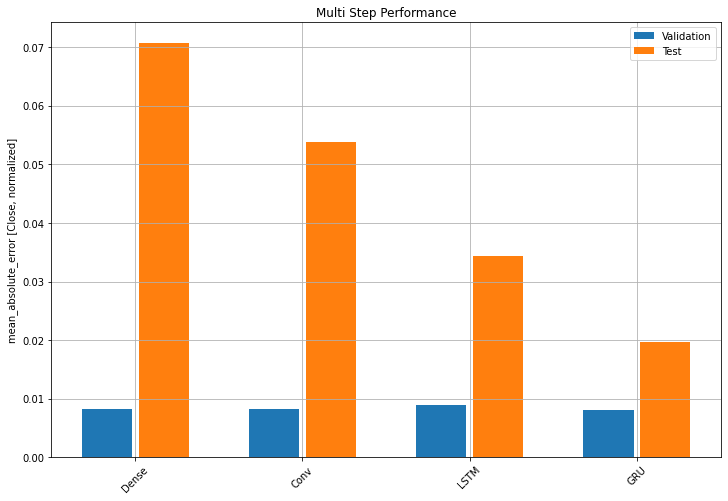

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.grid()
plt.title('Multi Step Performance')
plt.ylabel('mean_absolute_error [Close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()

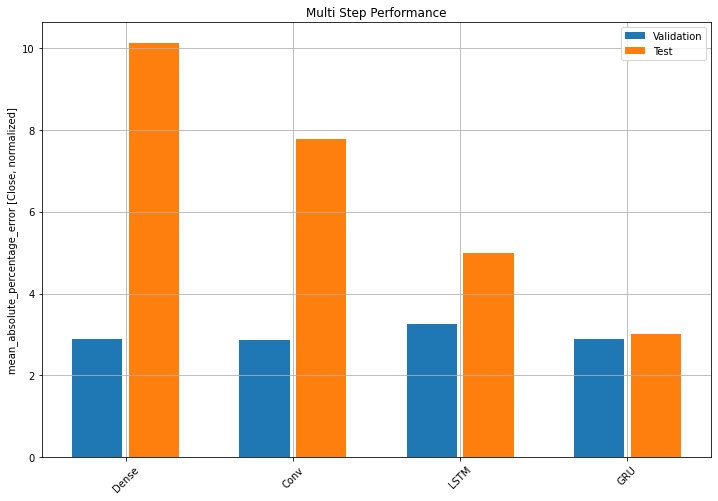

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_percentage_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.grid()
plt.title('Multi Step Performance')
plt.ylabel('mean_absolute_percentage_error [Close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()